# Step 1
    Data Loading and Preprocessing
    First, we'll load the data and preprocess it for our analysis.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

# Load the data
df = pd.read_csv("insurance_claims.csv")

# Handle missing values
df = df.fillna(0)

# Convert date columns to datetime
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Create new features
df['policy_age'] = (df['incident_date'] - df['policy_bind_date']).dt.days
df['claim_processing_time'] = (pd.to_datetime('now') - df['incident_date']).dt.days

# Encode categorical variables
categorical_columns = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 
                       'insured_occupation', 'insured_hobbies', 'insured_relationship', 
                       'incident_type', 'collision_type', 'incident_severity', 
                       'authorities_contacted', 'incident_state', 'incident_city', 
                       'property_damage', 'police_report_available', 'auto_make', 'auto_model']

le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Normalize numerical features
numerical_features = ['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 
                      'umbrella_limit', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 
                      'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 
                      'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year', 'policy_age', 'claim_processing_time']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Prepare features and target
X = df.drop(['fraud_reported', 'policy_number', '_c39', 'policy_bind_date', 'incident_date', 'incident_location', 'insured_zip'], axis=1)
y = df['fraud_reported'].map({'Y': 1, 'N': 0})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2
    Graph Construction
    Now, we'll construct a graph representation of our data using Neo4j.

In [2]:
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "Dairymilk@123"))

def create_policy_node(tx, row):
    tx.run("""
    CREATE (p:Policy {
        policy_number: $policy_number,
        policy_state: $policy_state,
        policy_csl: $policy_csl,
        policy_deductable: $policy_deductable,
        policy_annual_premium: $policy_annual_premium,
        umbrella_limit: $umbrella_limit
    })
    """, row.to_dict())

def create_insured_node(tx, row):
    tx.run("""
    CREATE (i:Insured {
        policy_number: $policy_number,
        age: $age,
        insured_sex: $insured_sex,
        insured_education_level: $insured_education_level,
        insured_occupation: $insured_occupation,
        insured_hobbies: $insured_hobbies,
        insured_relationship: $insured_relationship
    })
    """, row.to_dict())

def create_incident_node(tx, row):
    tx.run("""
    CREATE (inc:Incident {
        policy_number: $policy_number,
        incident_type: $incident_type,
        collision_type: $collision_type,
        incident_severity: $incident_severity,
        authorities_contacted: $authorities_contacted,
        incident_state: $incident_state,
        incident_city: $incident_city,
        incident_hour_of_the_day: $incident_hour_of_the_day,
        number_of_vehicles_involved: $number_of_vehicles_involved,
        property_damage: $property_damage,
        bodily_injuries: $bodily_injuries,
        witnesses: $witnesses,
        police_report_available: $police_report_available
    })
    """, row.to_dict())

def create_claim_node(tx, row):
    tx.run("""
    CREATE (c:Claim {
        policy_number: $policy_number,
        total_claim_amount: $total_claim_amount,
        injury_claim: $injury_claim,
        property_claim: $property_claim,
        vehicle_claim: $vehicle_claim,
        fraud_reported: $fraud_reported
    })
    """, row.to_dict())

def create_relationships(tx, row):
    tx.run("""
    MATCH (p:Policy {policy_number: $policy_number})
    MATCH (i:Insured {policy_number: $policy_number})
    MATCH (inc:Incident {policy_number: $policy_number})
    MATCH (c:Claim {policy_number: $policy_number})
    CREATE (i)-[:HAS_POLICY]->(p)
    CREATE (i)-[:INVOLVED_IN]->(inc)
    CREATE (inc)-[:RESULTED_IN]->(c)
    """, row.to_dict())

# Create nodes and relationships
with driver.session() as session:
    for _, row in df.iterrows():
        session.execute_write(create_policy_node, row)
        session.execute_write(create_insured_node, row)
        session.execute_write(create_incident_node, row)
        session.execute_write(create_claim_node, row)
        session.execute_write(create_relationships, row)

driver.close()

# Step 3
    Graph Analytics
    Now, we'll use graph analytics to extract additional features.

    Explanation: In this step, we run graph algorithms (PageRank, community detection, and betweenness centrality) to extract additional features from our graph structure. These features are then merged with our original dataset.

In [ ]:
driver = GraphDatabase.driver(uri, auth=("neo4j", "Dairymilk@123"))

def run_graph_algorithms(tx, graph_name):
    # PageRank to identify influential nodes
    tx.run(f"CALL gds.pageRank.write('{graph_name}', {{writeProperty: 'pagerank'}})")
    
    # Community detection
    tx.run(f"CALL gds.louvain.write('{graph_name}', {{writeProperty: 'community'}})")
    
    # Betweenness centrality
    tx.run(f"CALL gds.betweenness.write('{graph_name}', {{writeProperty: 'betweenness'}})")

# First, let's check what graphs are available in our database
def list_graphs(tx):
    result = tx.run("CALL gds.graph.list() YIELD graphName")
    return [record["graphName"] for record in result]

with driver.session() as session:
    available_graphs = session.read_transaction(list_graphs)
    print("Available graphs:", available_graphs)

    if available_graphs:
        graph_name = available_graphs[0]  # Use the first available graph
        print(f"Using graph: {graph_name}")
        session.execute_write(run_graph_algorithms, graph_name)
    else:
        print("No graphs available. Please create a graph projection first.")

# Extract graph features
query = """
MATCH (c:Claim)
RETURN c.policy_number AS policy_number, c.pagerank AS pagerank, 
       c.community AS community, c.betweenness AS betweenness
"""

with driver.session() as session:
    result = session.run(query)
    graph_features = pd.DataFrame([dict(record) for record in result])

driver.close()

# Merge graph features with original dataset
df = df.merge(graph_features, on='policy_number', how='left')

# Save the updated DataFrame to a new CSV file
df.to_csv('updated_insurance_claims_with_graph_features.csv', index=False)

print("Updated CSV file has been saved as 'updated_insurance_claims_with_graph_features.csv'")

C:\Users\harsh\AppData\Local\Temp\ipykernel_77192\74619045.py:19: DeprecationWarning: read_transaction has been renamed to execute_read
  available_graphs = session.read_transaction(list_graphs)
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: pagerank)} {position: line: 3, column: 44, offset: 60} for query: '\nMATCH (c:Claim)\nRETURN c.policy_number AS policy_number, c.pagerank AS pagerank, \n       c.community AS community, c.betweenness AS betweenness\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGN

Available graphs: []
No graphs available. Please create a graph projection first.
Updated CSV file has been saved as 'updated_insurance_claims_with_graph_features.csv'


# Step 4
    Model Training and Evaluation
    Now, we'll train a machine learning model and evaluate its performance.

    Explanation: We train a Random Forest classifier on our data, including the graph-derived features. We then evaluate its performance using a classification report and examine the most important features for fraud detection.

In [6]:
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)
print(feature_importance)

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       145
           1       0.52      0.24      0.33        55

    accuracy                           0.73       200
   macro avg       0.64      0.58      0.58       200
weighted avg       0.69      0.73      0.69       200

                  feature  importance
16      incident_severity    0.173360
10        insured_hobbies    0.059532
27           injury_claim    0.044242
28         property_claim    0.044190
5   policy_annual_premium    0.041298
29          vehicle_claim    0.038426
34  claim_processing_time    0.037516
33             policy_age    0.037127
26     total_claim_amount    0.036674
0      months_as_customer    0.035428


# Step 5
    Fraud Detection Visualization
    Finally, we'll visualize our fraud detection results using a network graph.

    Explanation: In this final step, we create a network visualization of our insurance claims, where nodes represent individual claims and edges represent shared characteristics. The color of each node indicates the predicted probability of fraud.

Number of nodes: 1000
Number of edges: 36966


C:\Users\harsh\AppData\Local\Temp\ipykernel_77192\2174019520.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


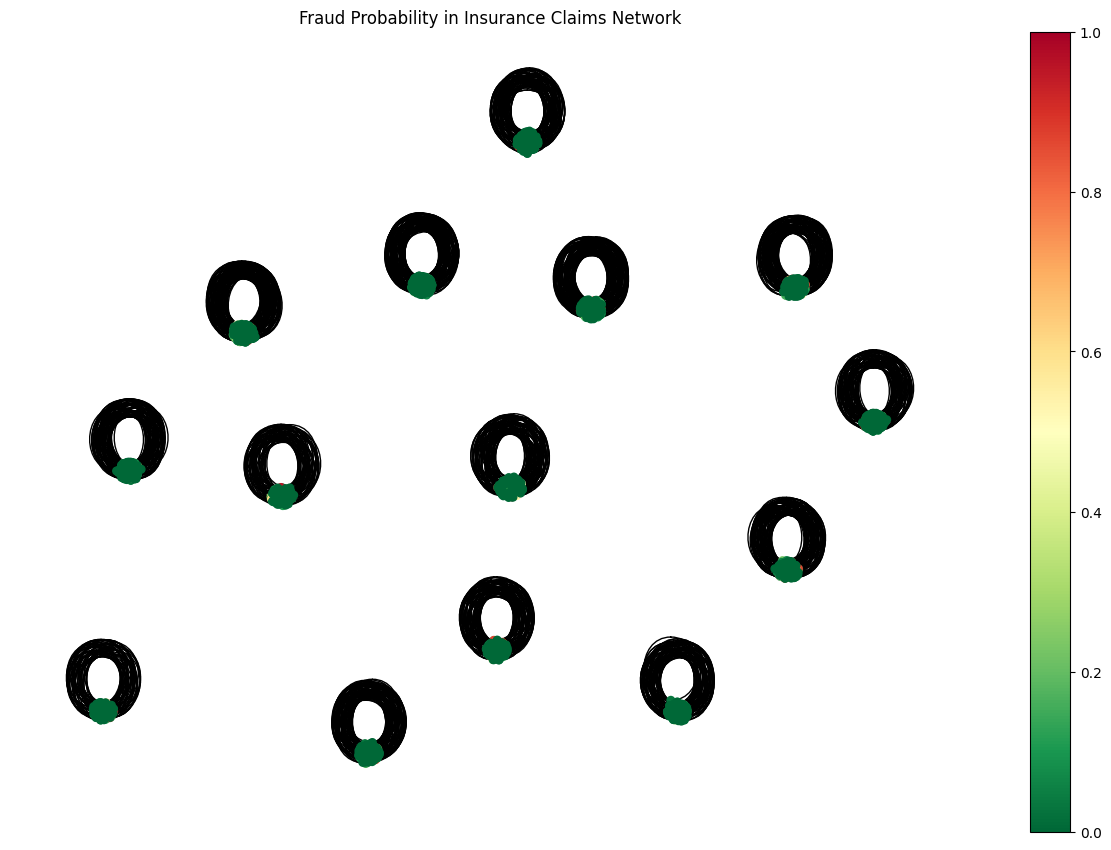

Mean fraud probability: 0.0883
Median fraud probability: 0.0000
Min fraud probability: 0.0000
Max fraud probability: 0.8900


In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a NetworkX graph
G = nx.Graph()

# Safely add nodes with attributes
for i, (_, row) in enumerate(df.iterrows()):
    if i < len(fraud_prob):
        G.add_node(row['policy_number'], fraud_prob=float(fraud_prob[i]))
    else:
        G.add_node(row['policy_number'], fraud_prob=0.0)  # Assign a default value
        print(f"Warning: fraud_prob array is shorter than DataFrame. Node {row['policy_number']} has no fraud probability.")

# Add edges based on shared characteristics (e.g., same insured_occupation)
for i, row1 in df.iterrows():
    for j, row2 in df.iloc[i+1:].iterrows():
        if row1['insured_occupation'] == row2['insured_occupation']:
            G.add_edge(row1['policy_number'], row2['policy_number'])

# Print the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Create a new figure with a specific size
plt.figure(figsize=(12, 8))

# Draw the graph
pos = nx.spring_layout(G)
node_colors = [G.nodes[n]['fraud_prob'] for n in G.nodes()]
nx.draw(G, pos, node_color=node_colors, node_size=30, cmap=plt.cm.RdYlGn_r, with_labels=False)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=plt.gca())

plt.title("Fraud Probability in Insurance Claims Network")
plt.tight_layout()
plt.show()

# Optional: Print some statistics about the fraud probabilities
fraud_probs = [G.nodes[n]['fraud_prob'] for n in G.nodes()]
print(f"Mean fraud probability: {np.mean(fraud_probs):.4f}")
print(f"Median fraud probability: {np.median(fraud_probs):.4f}")
print(f"Min fraud probability: {np.min(fraud_probs):.4f}")
print(f"Max fraud probability: {np.max(fraud_probs):.4f}")